In [1]:
# from maincode import Connect4Board
from random import randint

In [19]:
from maincode import Connect4Board

In [62]:
from random import randint
from math import sqrt, log2

class GameNode:
    def __init__(self, state, turn, parent) -> None:
        self.state = state
        self.turn = turn
        self.plays = 0
        self.wins = 0
        self.losses = 0
        self.parent = parent
        self.children = [None]*5


def move(state, col, player):
    # print("move col:", col)
    if state[col]!='0':
        return state
    else:
        temp = []
        temp[:0] = state
        # print(state)
        for i in range(5,-1,-1):
            if temp[5*i + col]=='0':
                temp[5*i + col]=chr(player+ord('0'))
                break
        state=""
        for i in temp:
            state += i
    # print(state)
    return state

def isWin(state, col, play):
    player = chr(play+ord('0'))
    row=5
    for row in range(5,-1,-1):
        if state[5*row + col]=='0':
            break
    row+=1

    # principal diag
    together=1
    if col>0:
        i=1
        while((i<=col and i<=row) and state[(row-i)*5 + col-i]==player):
            together+=1
            i+=1
    if col<4:
        i=1
        while((col+i<=4 and row+i<=5) and state[(row+i)*5 + col+i]==player):
            together+=1
            i+=1
    if together>=4:
        return True

    # other diagonal
    together=1
    if col>0:
        i=1
        while((i<=col and row+i<=5) and state[(row+i)*5 + col-i]==player):
            together+=1
            i+=1
    if col<4:
        i=1
        while((col+i<=4 and i<=row) and state[(row-i)*5 + col+i]==player):
            together+=1
            i+=1
    if together>=4:
        return True

    # horizontal
    together=1
    if col>0:
        i=1
        while(i<=col and state[row*5 + col-i]==player):
            together+=1
            i+=1
    if col<4:
        i=1
        while(col+i<=4 and state[row*5 + col+i]==player):
            together+=1
            i+=1
    if together>=4:
        return True

    # vertical
    together=1
    if row <=2:
        i=1
        while(row+i<=5 and state[(row+i)*5 + col]==player):
            together+=1
            i+=1
    if together==4:
        return True
    
    return False

def simulate(node, player):
    # print("sim: player =", player)
    curr = node.state
    highest = [0,0,0,0,0]
    for i in range(5):
        for j in range(5,-1,-1):
            if curr[j*5 + i]=='0':
                highest[i]=j
                break
    if max(highest)==0:
        return 0

    turn = player
    new = curr
    while True:
        act = randint(0,4)
        new = move(curr, act, turn)
        while new==curr:
            act = randint(0,4)
            # new = move(curr, act, turn)
            act+=1
        highest[act]-=1
        if isWin(new, act, turn):
            if turn==player:
                # print("retval=1")
                return 1
            else:
                # print("retval=-1")
                return -1
        elif max(highest)==0:
            break
        turn = turn^3
        curr=new
    # print("retval=0")
    return 0
        

def traverse(root):
    retval=0
    # exploration factor
    c = 1.1
    # print(root.state)
    
    if (not root.children[0]):
        # create 5 empty nodes
        # print("extension")
        for i in range(5):
            root.children[i] = GameNode(move(state=root.state, col=i, player=root.turn), root.turn ^ 3, root)
        # choose one of them at random
        next = randint(0,4)
        # print("next:", next)
        nextNode = root.children[next]
        # simulate it
        retval = simulate(nextNode, root.turn^3)
    else:
        # keep selecting nodes based on UCT
        nextNode = root.children[0]
        for node in root.children:
            # UCB(node) = wins/plays + C*sqrt(log2(Parent(node))/plays)
            if node.plays == 0:
                nextNode = node
                break
            elif node.wins/node.plays + c*sqrt(log2(root.plays/node.plays)) > nextNode.wins/nextNode.plays + c*sqrt(log2(root.plays/nextNode.plays)):
                nextNode = node
        retval = traverse(nextNode) * -1
    # print("back to trav")
    if retval==-1:
        root.wins += 1
    elif retval==1:
        root.losses += 1
    root.plays+=1
    return -retval

def mcts(root, n):
    # n = 10
    for i in range(n):
        traverse(root)
    
    newact = root.children.index(max(root.children, key=lambda node: node.plays))
    return newact

def qlearning(currstate):
    # choose a state either exploit or explore
    lr=0.8
    gamma = 1.5
    reward = -10
    prob = randint(0,9)
    newact=0
    if prob==1:
        newact = randint(0,4)
    else:
        newact = qtable[currstate].index(max(qtable[currstate]))

    # newstate = self.encoder()
    newstate = move(state=currstate, col=newact, player=2)

    # if state to new action doesn't exist make a new row, assign all q value in row to 5
    if newstate not in qtable:
        qtable[newstate] = [5,5,5,5,5]
    else:
        qtable[currstate][newact] += lr * (reward + gamma * max(qtable[newstate]) - qtable[currstate][newact])
    
    return newact

def main():
    # TODO: make sure game does not stall
    turn = 1
    action = 0
    global mctsroot1
    global mctsroot2 
    mctsroot1 = GameNode("000000000000000000000000000000", 1, None)
    mctsroot2 = GameNode("000000000000000000000000000000", 2, None)
    global mctscurr1
    global mctscurr2
    mctscurr1 = mctsroot1
    mctscurr2 = mctsroot2
    winTally1 = [0,0]
    # winTally2 = [0,0]

    global qtable
    qtable = {"000000000000000000000000000000": [1,1,1,1,1]}

    for j in range(10):
        while True:
            print()
            print(mctscurr2.state)
            if turn==1:
                action = mcts(mctscurr1, 40)
                mctscurr1 = mctscurr1.children[action]
                if (not mctscurr2.children[0]):
                    # create 5 empty nodes
                    for i in range(5):
                        mctscurr2.children[i] = GameNode(move(state=mctscurr2.state, col=i, player=mctscurr2.turn), mctscurr2.turn ^ 3, mctscurr2)
                mctscurr2 = mctscurr2.children[action]
            else:
                action = mcts(mctscurr2, 200)
                mctscurr2 = mctscurr2.children[action]
                if (not mctscurr1.children[0]):
                    # create 5 empty nodes
                    for i in range(5):
                        mctscurr1.children[i] = GameNode(move(state=mctscurr1.state, col=i, player=mctscurr1.turn), mctscurr1.turn ^ 3, mctscurr1)
                mctscurr1 = mctscurr1.children[action]
            if isWin(mctscurr1.state, action, turn):
                if turn==1:
                    print("MCTS40 has won")
                    winTally1[0]+=1
                else:
                    print("MCTS200 has won")
                    winTally1[1]+=1
                break
            turn = turn^3          
        print("game over")
    print("MCTS40:",winTally1[0])
    print("MCTS200:",winTally1[1])

main()


000000000000000000000000000000


KeyboardInterrupt: 

In [54]:
def isWin(state, col, player):
    row=5
    for row in range(6):
        if state[5*(5-row) + col]=='0':
            break
    row-=1
    print("row:",row)

    # principal diag
    together=1
    if col>0:
        i=1
        while((i<=col and i<=row) and state[(row-i)*5 + col-i]==player):
            together+=1
            i+=1
    if col<4:
        i=1
        while((col+i<=4 and row+i<=5) and state[(row+i)*5 + col+i]==player):
            together+=1
            i+=1
    if together>=4:
        return True

    # other diagonal
    together=1
    if col>0:
        i=1
        while((i<=col and row+i<=5) and state[(row+i)*5 + col-i]==player):
            together+=1
            i+=1
    if col<4:
        i=1
        while((col+i<=4 and i<=row) and state[(row-i)*5 + col+i]==player):
            together+=1
            i+=1
    if together>=4:
        return True

    # horizontal
    together=1
    if col>0:
        i=1
        while(i<=col and state[row*5 + col-i]==player):
            together+=1
            i+=1
    if col<4:
        i=1
        while(col+i<=4 and state[row*5 + col+i]==player):
            together+=1
            i+=1
    if together>=4:
        return True

    # vertical
    together=1
    if row <=2:
        i=1
        while(row+i<=5 and state[(row+i)*5 + col]==player):
            together+=1
            i+=1
    if together==4:
        return True
    
    return False
        

In [55]:
print(isWin("00002 10002 22102 11102 22111 11122", 2, 1))

row: 3
False


In [3]:
def printState(state):
    print("Board:")
    for i in range(6):
        for j in range (4):
            print(state[i*5 + j], end=", ")
        print (state[i*5 + 4])
        # print('\n', end="")
    
printState("020000100002002011020212202211")

Board:
0, 2, 0, 0, 0
0, 1, 0, 0, 0
0, 2, 0, 0, 2
0, 1, 1, 0, 2
0, 2, 1, 2, 2
0, 2, 2, 1, 1


In [ ]:
newboard = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
print(newboard)

print(len(newboard))
for i in range(6):
    print (newboard[i])

In [26]:
def move(state, col, player):
        if state[col]!='0':
            print("here")
            return state
        else:
            for i in range(5,-1,-1):
                print(i)
                if state[5*i + col]=='0':
                    state[5*i + col]=chr(player+ord('0'))
                    break
        return state

In [25]:
cs = ['0']*30
csn = move(cs, 2, 1)

print(csn)

5
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0']


In [39]:
def mover(state, col, player):
        if state[col]!='0':
            print("here")
            return state
        else:
            temp = []
            temp[:0] = state
            for i in range(5,-1,-1):
                print(i)
                # print(temp)
                if temp[5*i + col]=='0':
                    temp[5*i + col]=chr(player+ord('0'))
                    break
                print(temp)
            state=""
            for i in temp:
                state += i
        return state

In [40]:
cs1 = "000000000000000000000000000000"
csn1 = mover(cs1, 4, 1)

print(csn1)

5
000000000000000000000000000001


In [61]:
sq = {0: 2, 1:5, 2:4, 3:-8, 4:-1,}
maxsq = max(sq, key=lambda i: sq.get(i)*sq.get(i))
print(maxsq)
# print(sq.index(maxsq))

3


In [ ]:
# lr = 0.05, 0.1, 0.15, 0.2, 0.25, 0.5
# gamma = 0.2, 0.4, 0.6, 0.8, 1

In [ ]:
# lr = 0.1
# gamma = 0.2: 842 1158
# gamma = 0.2: 128 1872
[40, 44, 58, 54, 48, 42, 28, 44, 34, 40, 36, 48, 46, 44, 54, 40, 42, 44, 44, 38, 44, 54, 38, 56, 38, 46, 30, 30, 42, 50, 46, 34, 46, 40, 42, 48, 52, 40, 36, 44]
[54, 68, 94, 76, 96, 100, 100, 96, 100, 100, 88, 100, 100, 100, 100, 100, 100, 100, 100, 100]
# gamma = 0.4: 941 1059
# gamma = 0.4: 132 1868
[42, 42, 50, 42, 42, 52, 44, 54, 40, 52, 48, 34, 42, 32, 42, 44, 48, 44, 38, 44, 34, 42, 48, 42, 42, 32, 38, 38, 54, 48, 32, 46, 34, 40, 44, 34, 44, 46, 44, 48]
[66, 64, 68, 70, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
# gamma = 0.6: 947 1053
# gamma = 0.6: 556 1544
[58, 72, 80, 80, 80, 80, 80, 80, 80, 80, 70, 72, 70, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 64, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
[0, 2, 34, 40, 48, 46, 100, 74, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
# gamma = 0.8: 112 1888
[64, 54, 72, 98, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
# gamma = 1.0: 212 1788
[30, 54, 48, 68, 94, 98, 100, 100, 100, 100, 96, 100, 100, 100, 100, 100, 100, 100, 100, 100]

In [4]:
import matplotlib.pyplot as plt

In [25]:
l1 = [42, 42, 50, 42, 42, 52, 44, 54, 40, 52, 48, 34, 42, 32, 42, 44, 48, 44, 38, 44, 34, 42, 48, 42, 42, 32, 38, 38, 54, 48, 32, 46, 34, 40, 44, 34, 44, 46, 44, 48]
l2 = [58, 72, 80, 80, 80, 80, 80, 80, 80, 80, 70, 72, 70, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 64, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
for i in range(len(l1)):
    l1[i]*= 1.25
    l2[i]*= 1.25
print(l1)
print(l2)

[52.5, 52.5, 62.5, 52.5, 52.5, 65.0, 55.0, 67.5, 50.0, 65.0, 60.0, 42.5, 52.5, 40.0, 52.5, 55.0, 60.0, 55.0, 47.5, 55.0, 42.5, 52.5, 60.0, 52.5, 52.5, 40.0, 47.5, 47.5, 67.5, 60.0, 40.0, 57.5, 42.5, 50.0, 55.0, 42.5, 55.0, 57.5, 55.0, 60.0]
[72.5, 90.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 87.5, 90.0, 87.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 80.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


<function matplotlib.pyplot.show(close=None, block=None)>

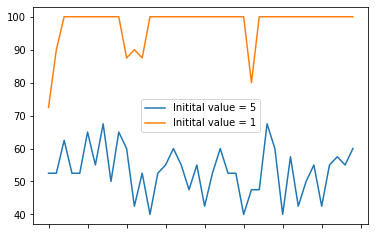

In [28]:
plt.plot(l1, label = "Initital value = 5")
plt.plot(l2, label = "Initital value = 1")
plt.legend()
plt.xlabel=None
figure = plt.gca()

figure.axes.xaxis.set_ticklabels([])

plt.show